In [2]:
import canny
import hough
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 8]

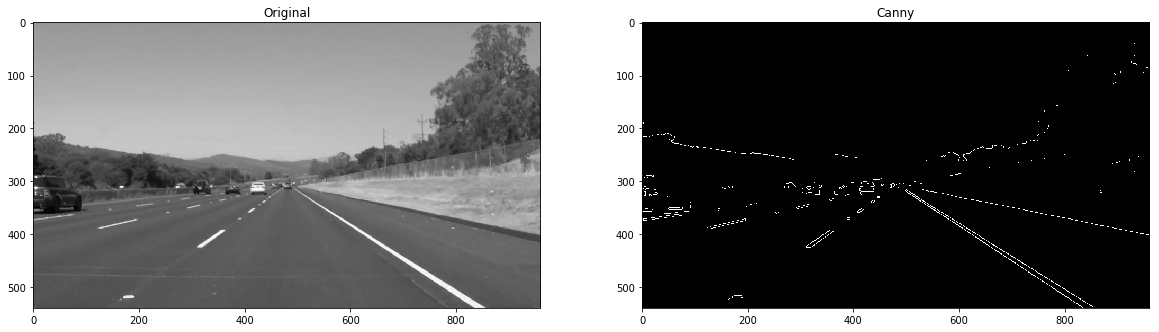

In [3]:
img = cv2.imread('img/lane1.jpg',0)
img_edges = canny.Canny(img)

fig = plt.figure(figsize=(20, 18))
a = fig.add_subplot(1,2,1)
plt.imshow(img,'gray')
a.set_title('Original')
a = fig.add_subplot(1,2,2)
plt.imshow(img_edges,'gray')
a.set_title('Canny')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


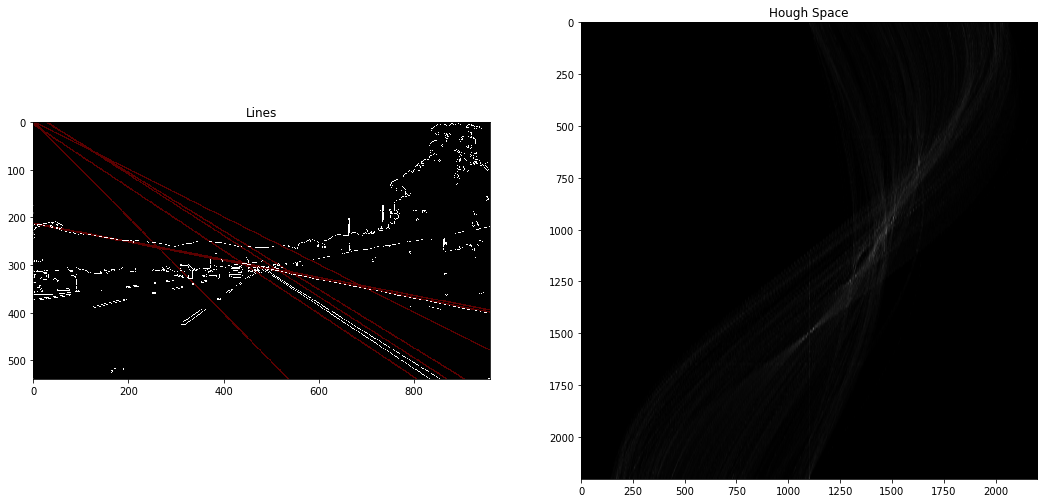

In [4]:
mask = cv2.imread('img/mask.jpg',0)
edges = cv2.Canny(img,100,200)
lines = hough.HoughLines(edges)

fig = plt.figure(figsize=(18, 18))
a = fig.add_subplot(1,2,1)
plt.imshow(lines[0])
a.set_title('Lines')
a = fig.add_subplot(1,2,2)
plt.imshow(lines[1],'gray')
a.set_title('Hough Space')
plt.show()

In [6]:
import cv2
import numpy as np

img = cv2.imread('img/lane3.jpg')

def func(img):
    # mask = cv2.imread('img/mask.jpg',0)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    mask = np.zeros(gray.shape)
    mask[int(gray.shape[0]*0.5):,:] = 1
    # mask = cv2.resize(mask, (gray.shape[1],gray.shape[0])) 
    edges = cv2.Canny(gray,100,300)
    edges = (mask/255)*edges
    edges = cv2.normalize(src=edges, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    lines = cv2.HoughLines(edges,1,np.pi/180,75)
    # for line in lines:
    #     for rho,theta in line:
    #         a = np.cos(theta)
    #         b = np.sin(theta)
    #         x0 = a*rho
    #         y0 = b*rho
    #         x1 = int(x0 + 1000*(-b))
    #         y1 = int(y0 + 1000*(a))
    #         x2 = int(x0 - 1000*(-b))
    #         y2 = int(y0 - 1000*(a))

    #         cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    if lines.shape[0] == 0:
        exit()
    lines2 = []
    for line in lines:
        for rho,theta in line:
            lines2.append(tuple((rho, theta)))
    lines2.sort()
    sorted_lines = [[]]
    sorted_lines[0].append(lines2[0])
    prev_rho = lines2[0][0]
    group = 0
    thresh = 20
    for line in lines2[1:]:
        if line[1] > np.deg2rad(90 + thresh) or line[1] < np.deg2rad(90-thresh):
            if np.abs(line[0] - prev_rho) < 70:
                sorted_lines[group].append(line)
            else:
                group += 1
                sorted_lines.append([])
                sorted_lines[group].append(line)
            prev_rho = line[0]

    avg_lines = []
    for line_group in sorted_lines:
        rho_sum = 0
        theta_sum = 0
        for line in line_group:
            rho_sum += line[0]
            theta_sum += line[1]
        rho_avg = rho_sum/len(line_group)
        theta_avg = theta_sum/len(line_group)
        avg_lines.append((rho_avg, theta_avg))
    img_lines = img.copy()
    for line in avg_lines:
        a = np.cos(line[1])
        b = np.sin(line[1])
        x0 = a*line[0]
        y0 = b*line[0]
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 4000*(-b))
        y2 = int(y0 - 4000*(a))

        cv2.line(img_lines,(x1,y1),(x2,y2),(0,0,255),2)
    img_lines[0:int(img.shape[0]*(0.6)),:] = img[0:int(img.shape[0]*(0.6)),:]
    plt.imshow(mask,'gray')
    return img_lines
# plt.imshow(img_lines,'gray')
# print(avg_lines)

In [ ]:
cap = cv2.VideoCapture('vids/lane1.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
    res = func(frame)
#     res = cv2.Canny(frame,100,300)

    cv2.imshow('frame',res)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()